# Стадия III

Код учитывает в простом варианте сопротивление атмосферы: сила направлена против скорости и пропорциональна скорости объекта, плотности атмосферы. 

Плотность атмосферы рассчитывается согласно модели (интерполяция по точкам).

Код учитывает неоднородность гравитационного поля Земли по аналитической формуле из Википедии.

In [1]:
!cd ../ &&\
nvcc src/gpu_main.cu \
src/gpu/gpu_solver.cu \
src/model.cu \
-o bin/gpu_spacejunk.exe

src/gpu/gpu_solver.cu(21): warning: variable "pi" was declared but never referenced

src/gpu/gpu_solver.cu(28): warning: variable "M" was declared but never referenced

src/gpu/gpu_solver.cu(29): warning: variable "G" was declared but never referenced

src/gpu/gpu_solver.cu(166): warning: variable "pi" was declared but never referenced

src/gpu/gpu_solver.cu(173): warning: variable "M" was declared but never referenced

src/gpu/gpu_solver.cu(174): warning: variable "G" was declared but never referenced

src/gpu/gpu_solver.cu(175): warning: variable "R" was declared but never referenced

src/gpu/gpu_solver.cu(232): warning: variable "dt1" was declared but never referenced

src/gpu/gpu_solver.cu(233): warning: variable "dh" was declared but never referenced



In [2]:
import os
import matplotlib.pyplot as plt
import subprocess
import json
import math
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def run_simulation(time, dt, 
                   steps, max_steps, 
                   objects, forces, 
                   log_trajectories=[0], 
                   collision_option="disabled"):
    """Python wrapper for execute cuda binary. Works via config files.
    Saves txt files with trajectories and collisions. 
    Объект - массив из 7 чисел: 
    x, y, z, vx, vy, vz, size - начальное положение, скорость и размер
    Args:
        time (double): время начала моделирования, с ()
        dt (double): интервал, через который считается новая позиция, с
        steps (int): кол-во итераций
        maxSteps (int): максимальное кол-во шагов, которое будет за 1 раз промоделировано на GPU
        objects (np.array): массив объектов. 
        forces (list of str): массив строк-идентификаторов сил
        log_trajectories (list of int): массив из индексов объектов
        collision_options (str): "disabled" - не ищем коллизии, если "slow" - то ищем за квадрат, иначе - ищем быстрым алгоритмом
        
    Returns:
        trajectories (dict): словарь {индекс объекта : массив из его траекторий}
        collisions (array): массив троек: (время, id объекта, id объекта)
        
    """
    with open("./cfg.txt", "w") as f:
        f.write(' '.join([str(x) for x in [time, dt, max_steps, steps]]) + '\n')
        f.write(str(len(objects)) + '\n')
        for obj in objects:
            f.write(' '.join([str(x) for x in obj]) + '\n')
        f.write(str(len(log_trajectories)) + '\n')
        f.write(' '.join([str(x) for x in log_trajectories]) + '\n')
        f.write(str(len(forces)) + '\n')
        f.write(' '.join(forces) + '\n')
        f.write("trajectories.txt\n")
        f.write("collisions.txt\n")
        f.write("\n")
        
    FNULL = open(os.devnull, 'w')
    args = ["../bin/gpu_spacejunk.exe",  "./cfg.txt"]
    res = subprocess.call(args, stdout=FNULL, stderr=FNULL, shell=False)
    if res:
        return None
    
    trajectories = {}
    with open("trajectories.txt") as tr:
        if tr:
            line = tr.readline()
            cur_id = None
            while (line):
                coords = line.split()
                if len(coords) == 1:
                    cur_id = int(coords[0])
                    trajectories[cur_id] = []
                else:
                    trajectories[cur_id].append([float(x) for x in coords])
                line = tr.readline()
    
    collisions = []
    with open("collisions.txt") as coll:
        if coll:
            line = coll.readline()
            while (line):
                collision = line.split()
                collisions.append((float(collisions[0]), int(collision[1]), int(collisions[2])))
                line = coll.readline()
    return trajectories, collisions

def draw_trajectories(trajectories):
    fig = pyplot.figure()
    ax = Axes3D(fig)
    for index, points in trajectories.items():
        period = 1
        # Oooh
        if len(points) > 100:
            period = 1
            if len(points) > 1000:
                period = len(points) //100
                if len(points) > 100000:
                    period = len(points) //10000
      
        x_coord = [i[0] for i in points[::period]]
        y_coord = [i[1] for i in points[::period]]
        z_coord = [i[2] for i in points[::period]]
        ax.scatter(x_coord, y_coord, z_coord)
    pyplot.show()
    
    
    

In [3]:
M = 5.972e24
R = 6.371e6
G = 6.67408e-11

x_obj = 0.0
y_obj = 1.01 * R
z_obj = 0.0

vx_obj = (G * M / (1.2 * R)) ** 0.5
vy_obj = 0.0
vz_obj = 0.0

MU =  3.986004418e14

timestep = 1.0
day = (1/timestep)*3600*24
simulation_time = day
print('Simulation_time =', simulation_time, 'steps')

Simulation_time = 86400.0 steps


# Simple gravity

In [4]:
res = run_simulation(time = 0.0, 
                     dt = 1.0, 
                     steps =  int(simulation_time), 
                     max_steps = 10000, 
                     objects = [[x_obj, y_obj, z_obj,
                                vx_obj, vy_obj, vz_obj, 0]], 
                     forces = ['gravity'],
                     log_trajectories=[0])

In [5]:
res[0][0][-1][:3]

[-963081.8835570011, 6348409.376481048, 0.0]

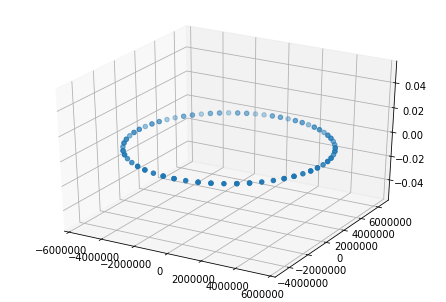

In [6]:
draw_trajectories(res[0])

# Heterogenius gravity

In [7]:
res = run_simulation(time = 0.0, 
                     dt = 1.0, 
                     steps =  int(simulation_time), 
                     max_steps = 10000, 
                     objects = [[x_obj, y_obj, z_obj,
                                vx_obj, vy_obj, vz_obj, 0]], 
                     forces = ['heterogeneous_gravity'],
                     log_trajectories=[0])

In [8]:
res[0][0][-1][:3]

[-962909.2638462192, 6348439.764116557, 0.0]

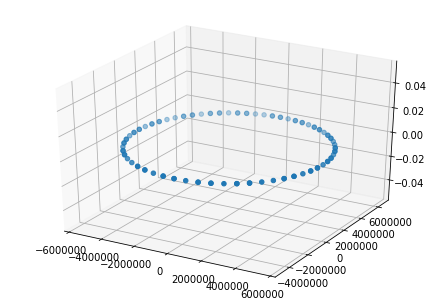

In [9]:
draw_trajectories(res[0])

# Air grag

In [10]:
!cd ../ &&\
nvcc src/gpu_main.cu \
src/gpu/gpu_solver.cu \
src/model.cu \
-o bin/gpu_spacejunk.exe

src/gpu/gpu_solver.cu(21): warning: variable "pi" was declared but never referenced

src/gpu/gpu_solver.cu(28): warning: variable "M" was declared but never referenced

src/gpu/gpu_solver.cu(29): warning: variable "G" was declared but never referenced

src/gpu/gpu_solver.cu(166): warning: variable "pi" was declared but never referenced

src/gpu/gpu_solver.cu(173): warning: variable "M" was declared but never referenced

src/gpu/gpu_solver.cu(174): warning: variable "G" was declared but never referenced

src/gpu/gpu_solver.cu(175): warning: variable "R" was declared but never referenced

src/gpu/gpu_solver.cu(232): warning: variable "dt1" was declared but never referenced

src/gpu/gpu_solver.cu(233): warning: variable "dh" was declared but never referenced



In [11]:
res = run_simulation(time = 0.0, 
                     dt = 1.0, 
                     steps =  int(simulation_time), 
                     max_steps = 10000, 
                     objects = [[x_obj, y_obj, z_obj,
                                vx_obj, vy_obj, vz_obj, 0]], 
                     forces = ['gravity', 'air_drag'],
                     log_trajectories=[0])

In [12]:
res[0][0][-1][:3]

[-968301.9161430916, 6349494.635962807, 47.29589341972053]

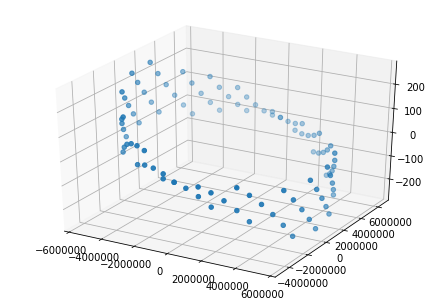

In [13]:
draw_trajectories(res[0])